# Bay Wheels Data Analysis
## How does user type and day of week affect the nature of ride 
## Yu Okamura

## Investigation Overview

> In this investigation, I would like to look at the factors that affect the number and duration of rides.  I will focus on difference between weekend/weekday and user type.

## Dataset Overview

> The data consists of all the rides made during year 2019 in the greater San Francisco Bay area.  There are total of 2500000 data points.  One data point with extremely long ride duration (nearly 25h) was removed.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import glob
import os
# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
# list all the csv files in data folder
path = os.getcwd()
all_files = glob.glob(os.path.join(path,'data\*.csv'))

# read csv files in the list and concatnate to create one dataframe
df = pd.concat((pd.read_csv(file, 
                            dtype={"bike_share_for_all_trip":'string','rental_access_method':'string'}) for file in all_files), 
               ignore_index=True)

In [4]:
# change incorrect datatypes and create a new column with minutes
df['start_time']=pd.to_datetime(df['start_time'])
df['end_time']=pd.to_datetime(df['end_time'])

df['duration_min']=df.loc[:,'duration_sec'] / 60

# add new column to the table
df['day_of_week']=df.loc[:,'start_time'].dt.day_name()
df['hour'] = df.loc[:,'start_time'].dt.hour

# define funciton to return weekday or weekend depending on the dayofweek value (0-4:Mon-Fri,5-6: sat-sun)
def day_of_week(time):
    day = time.dayofweek
    if day < 5:
        return 'Weekday'
    else:
        return 'Weekend'
df['day_of_week']=df.loc[:,'start_time'].apply(lambda x: day_of_week(x))

ordinal_var_dict = {'day_of_week': ['Weekday','Weekend'],
                    'user_type':['Subscriber', 'Customer']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

In [5]:
# remove outlier
df = df[df.duration_sec!=df.duration_sec.max()]

## Distribution of the Duration of Rides
> The duration of rides in the dataset ranged from a few minutes to almost 24hours.  The distribution is right-skewed and most of the rides are under 30minutes.  Plotted on the logarithmic scale, the distribution becomes bell shaped.

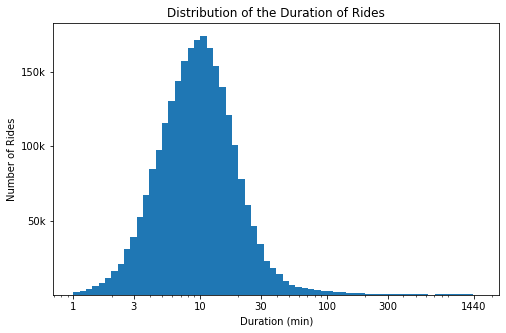

In [6]:
bin_size = 0.05
bin_edges = 10** np.arange(0,np.log10(df.duration_min.max())+ bin_size, bin_size)

plt.figure(figsize=[8,5])
plt.hist(data=df, x='duration_min', bins=bin_edges);

plt.title('Distribution of the Duration of Rides')
plt.xlabel('Duration (min)')
plt.ylabel('Number of Rides')

tick_loc = [1,3,10,30,100,300,1440]
plt.xscale('log')
plt.xticks(tick_loc,tick_loc)
plt.yticks([5e4, 1e5, 1.5e5],['50k','100k','150k']);

## The Proportion of User Type

> There are two user types in the system; subsribers and customers.  The 80% of total rides came from subscribers.

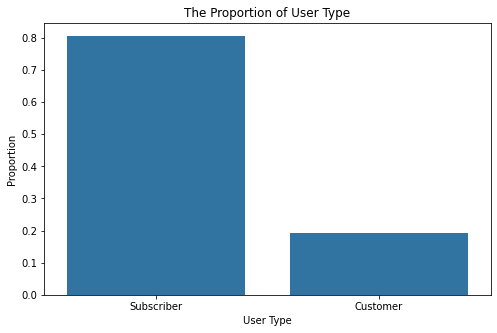

In [7]:
# plot in proportion
base_color = sns.color_palette()[0]
n_points = df.shape[0]
max_count = df['user_type'].value_counts().max()
max_prop = max_count/n_points 

plt.figure(figsize=[8,5])
tick_props = np.arange(0,max_prop,0.1)
tick_names = ['{:0.1f}'.format(v) for v in tick_props]
sns.countplot(data=df, x='user_type', color=base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.title('The Proportion of User Type')
plt.ylabel('Proportion')
plt.xlabel('User Type');

## Hourly Variation in Number of Rides
### Effect of User Type and Day of Week
> There is very interesting difference in pattern that can be observed here.  During weekday, the distribution is bimodal with peaks around 8 and 17 o'clock.  On the other hand, there is one broad peak during early afternoon during weekend.  The pattern is the same for both subscribers and customers, but subscribers has much sharper peak during weekday.

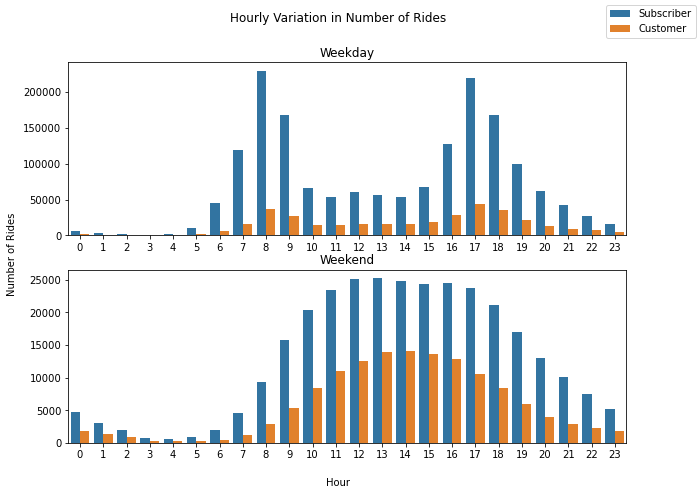

In [10]:
# since the trend on weekeday and weekend seem to differ, lets see how the hourly usage change on these separate occasions. 
fig, ax = plt.subplots(nrows=2, figsize=(10,7))
sns.countplot(data=df[df['day_of_week']=='Weekday'], x='hour', hue='user_type', ax=ax[0])
sns.countplot(data=df[df['day_of_week']=='Weekend'], x='hour', hue='user_type', ax=ax[1])

for i in range(2):
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].get_legend().remove()
ax[0].set_title('Weekday')
ax[1].set_title('Weekend')

fig.suptitle('Hourly Variation in Number of Rides')
fig.text(0.5, 0.04, 'Hour', ha='center')
fig.text(0.04, 0.5, 'Number of Rides', va='center', rotation='vertical')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='best');

# Hourly Variation in Duration of Rides
> Similarly to the previous slide, the following plots show the difference in duration of raides for weekday/weekend, and the types of user.  It is very noticeable that the customers have much longer ride time than those of subscribers.  This trend is regardless of the weekday/weekend and hour.  Also the ride time is very consistent for subscribers, where the mean ranges from 10-15mins.  On the other hand, customer's duration fluctuate more throughout the day.  It seems bimodal with a sharp peak around 3-4 and a broader peak around 13. 

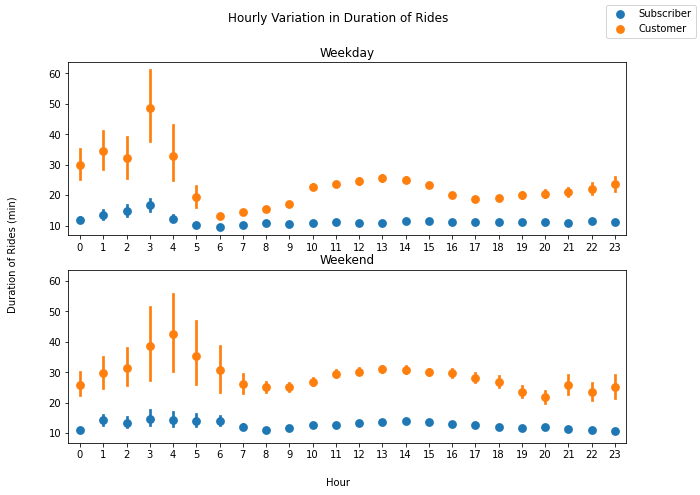

In [11]:
fig, ax = plt.subplots(nrows=2, figsize=(10,7), sharey=True)
sns.pointplot(data=df[df['day_of_week']=='Weekday'], x='hour',y='duration_min', hue='user_type', ax=ax[0], linestyles='')
sns.pointplot(data=df[df['day_of_week']=='Weekend'], x='hour', y='duration_min', hue='user_type', ax=ax[1], linestyles='')

for i in range(2):
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].get_legend().remove()
ax[0].set_title('Weekday')
ax[1].set_title('Weekend')

fig.suptitle('Hourly Variation in Duration of Rides')
fig.text(0.5, 0.04, 'Hour', ha='center')
fig.text(0.04, 0.5, 'Duration of Rides (min)', va='center', rotation='vertical')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='best');